In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys
import matplotlib as mpl
from matplotlib.colors import LogNorm
import icomo
import diffrax

sys.path.append("../src/")
from tapm import utils

In [60]:
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")
lambdaP = 1 / 360  # 1,2,4
betaSTI = 0.008  # 0.0016 *[3, 5, 7]

In [61]:
T = 365*10
ts = np.linspace(0, T, T)
y0 = {
    "S": 0.99,  # Initial susceptible proportion
    "Ia": 0.009,  # Initial asymptomatic proportion
    "Is": 0.001,  # Initial symptomatic proportion
}


integrator = icomo.ODEIntegrator( # integrates ODE system
    ts_out=ts, # time points for output
    t_0=ts[0], # from time 0
    t_1=ts[-1], # to time T
    ts_solver=ts, # time points for solving the ODE
    ts_arg=ts, # time points for time-dependent argument
    interp="cubic", # interpolation method
    solver=diffrax.Bosh3(),  # a 3rd order method
    adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints=len(ts)),
)

def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))

# ODE system
def SIaIsS(t, y, arguments):
    β, args = arguments # beta is time-dependent argument, other args are constant
    P = args["P"]
    H = args["H"]
    # ODEs
    Lambda = args['beta_STI'] * (1-m(P,H)*(1-P)) * (y["Ia"] + y["Is"]) 
    dS = -Lambda * y["S"] + args['gamma_STI'] * y["Ia"] + args['gammaT_STI'] * (1-y["Is"]-y["Ia"]-y["S"]) + args['mu'] - args['mu'] * y["S"] - args['Sigma']
    dIa = args['psi'] * Lambda * y["S"] -  args['gamma_STI'] * y["Ia"] - lambdaa(P,H)*y["Ia"] - args['mu'] * y["Ia"] + args['psi'] *args['Sigma']
    dIs = (1-args['psi']) * Lambda * y["S"] - lambdas(P,H)*y['Is'] - args['mu'] * y["Is"] + (1-args['psi']) * args['Sigma']
    dy = {"S": dS, "Ia": dIa, "Is": dIs}
    return dy

SIRS_integrator = integrator.get_func(SIaIsS) # give ODE system to integrator
const_args = args

Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)




## Fixed points calculation (Laura new)

---------P:  0.0  H:  0.0
Ia: 0.6826635899004774 Is:  0.0036501706608745793 S: 0.3118619422579185
Iaminus: 0.6729688120817672 Is:  0.0035983197927814455 Sminus: 0.31178893155412246
---------P:  0.0  H:  0.022222222222222223
Ia: 0.36183139525274594 Is:  0.0034219268670228013 S: 0.6285610277531034
Iaminus: 0.342637773064111 Is:  0.003234052876147192 Sminus: 0.6267038259822296
---------P:  0.0  H:  0.044444444444444446
Ia: 0.07502407547553197 Is:  0.0009559343766494192 S: 0.9218773386367208
Iaminus: nan Is:  nan Sminus: nan
---------P:  0.0  H:  0.06666666666666667
Ia: 0.015418199877259748 Is:  0.00022913852264898912 S: 0.9837775534087289
Iaminus: -0.017469790361166197 Is:  -0.00025955459767291865 Sminus: 1.5584234180301937
---------P:  0.0  H:  0.08888888888888889
Ia: 0.008339583373405584 Is:  0.00013821584766733605 S: 0.9911553762898555
Iaminus: -0.008596552853209484 Is:  -0.00014247485777877037 Sminus: 2.2323627465180325
---------P:  0.0  H:  0.11111111111111112
Ia: 0.00607195323413121

/tmp/ipykernel_251229/3688584738.py:17: RuntimeWarning: invalid value encountered in sqrt
  return (-bL(P,H) - np.sqrt(bL(P,H)**2 - 4*aL(P,H)*dL(P,H))) / (2*aL(P,H))


Iaminus: -0.025573329232139116 Is:  -0.00037126314850202175 Sminus: 1.3806779118650645
---------P:  0.1111111111111111  H:  0.08888888888888889
Ia: 0.010205682032861567 Is:  0.0001638151063872745 S: 0.9892025179900101
Iaminus: -0.010714243217029918 Is:  -0.00017197706188861475 Sminus: 1.9360387464732567
---------P:  0.1111111111111111  H:  0.11111111111111112
Ia: 0.00727158475855001 Is:  0.00012475292104721978 S: 0.9922670647734536
Iaminus: -0.007436289523368445 Is:  -0.00012757871809093003 Sminus: 2.4666930221599137
---------P:  0.1111111111111111  H:  0.13333333333333333
Ia: 0.005924795119946682 Is:  0.0001061532655098696 S: 0.9936768334644379
Iaminus: -0.006006450332345807 Is:  -0.00010761627717092049 Sminus: 2.981361462902133
---------P:  0.1111111111111111  H:  0.15555555555555556
Ia: 0.005184449975888842 Is:  9.539191707262889e-05 S: 0.9944543974921581
Iaminus: -0.005234821612949764 Is:  -9.63187385078064e-05 Sminus: 3.47961715758592
---------P:  0.1111111111111111  H:  0.1777777

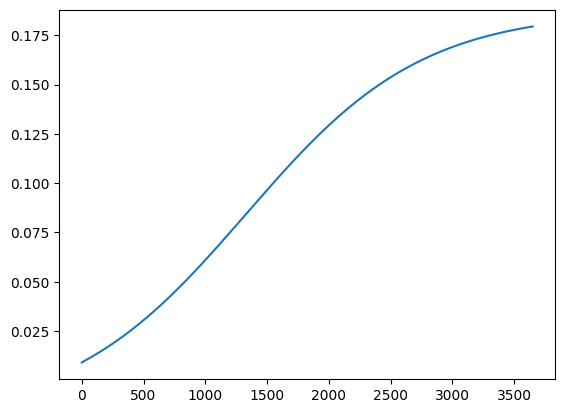

In [68]:
def f(P,H):
    return (lambdas(P,H)+args["mu"]) / (1-args["psi"])

def Splus(P,H):
    return (f(P,H)*Iaplus(P,H)*c(P,H)-args['Sigma']) / (kappa(P,H)*Iaplus(P,H)*(1+c(P,H)))
    
def Sminus(P,H):
    return (f(P,H)*Iaminus(P,H)*c(P,H)-args['Sigma']) / (kappa(P,H)*Iaminus(P,H)*(1+c(P,H)))
    
def c(P,H):
    return ((1-args['psi'])*(args['gamma_STI']+lambdaa(P,H)+args['mu'])) / (args['psi']*(lambdas(P,H)+args['mu']))

def Iaplus(P,H):
    return (-bL(P,H) + np.sqrt(bL(P,H)**2 - 4*aL(P,H)*dL(P,H))) / (2*aL(P,H))

def Iaminus(P,H):
    return (-bL(P,H) - np.sqrt(bL(P,H)**2 - 4*aL(P,H)*dL(P,H))) / (2*aL(P,H))

def aL(P,H):
    return kappa(P,H) * (args['gamma_STI']-args['gammaT_STI']+c(P,H)**2*(-f(P,H)-args['gammaT_STI'])+c(P,H)*(-f(P,H)+args['gamma_STI']-2*args['gammaT_STI']))

def bL(P,H):
    return kappa(P,H)*(args['gammaT_STI']+args['mu'])*(1+c(P,H))+c(P,H)*(args['mu']-args['gammaT_STI'])*f(P,H)

def dL(P,H):
    return args['Sigma']*(args['mu']-args['gammaT_STI'])

def kappa(P,H):
    return args['beta_STI'] * (1-m(P,H)*(1-P))
def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
def R0(P, H):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])

Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)

for P in Ps:
    for H in Hs:
        const_args["P"] = P
        const_args["H"] = H
        output = SIRS_integrator(y0=y0, arg_t=np.ones(T), constant_args=const_args)
        if True:#R0(P,H) < 1:
            print("---------P: ",P," H: ",H)
            # sol from sim
            print("Ia:", output['Ia'][-1], "Is: ", output['Is'][-1],"S:", output['S'][-1])
            # sol from formula
            #print("Iaplus:", Iaplus(P,H), "Is: ", c(P,H)*Iaplus(P,H),"Splus:", Splus(P,H))
            #print("..Iaminus:", args['psi']*((args['Sigma'])/(args['gammaT_STI']+args['mu'])), "Is: ", (1-args['psi'])*((args['Sigma'])/(args['gammaT_STI']+args['mu'])), "Sminus:", 1-(args['Sigma'])/(args['gammaT_STI']+args['mu']))
            print("Iaminus:", Iaminus(P,H), "Is: ", c(P,H)*Iaminus(P,H), "Sminus:", Sminus(P,H))


const_args["P"] = 0.8888888888888888
const_args["H"] = 0.15555555555555556
output = SIRS_integrator(y0=y0, arg_t=np.ones(T), constant_args=const_args)
print("---------P: ",P," H: ",H)
plt.plot(output['Ia'])



## Fixed points Calculation (New)

In [4]:
def Splus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (D(P,H)*Iaplus(P,H)+args["Phi"]-args["Sigma"])/(kappa(P,H)*(1+C(P,H))*Iaplus(P,H)+args["mu"])
def Sminus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (D(P,H)*Iaminus(P,H)+args["Phi"]-args["Sigma"])/(kappa(P,H)*(1+C(P,H))*Iaminus(P,H)+args["mu"])

def C(P,H):
    return ((args["gamma_STI"]+lambdaa(P,H)+args["mu"])*(1-args['psi']))/(args["psi"]*(lambdas(P, H)+args["mu"]))

def D(P,H):
    return args["gamma_STI"]+ (args["gammaT_STI"]*(lambdaa(P,H)+lambdas(P,H)*C(P,H)))/(args["gammaT_STI"]+args["mu"])

def a(P,H):
    return kappa(P,H)*(1+C(P,H))*(D(P,H)-(args["gamma_STI"]+args["mu"]+lambdaa(P,H))/args["psi"])

def b(P,H):
    return kappa(P,H)*(1+C(P,H))*args["Phi"]-((args["gamma_STI"]+args["mu"]+lambdaa(P,H))/args["psi"])*args["mu"]

def d(P,H):
    return args["Sigma"]*args["mu"]

def kappa(P,H):
    return args['beta_STI'] * (1-m(P,H)*(1-P))
def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
def R0(P, H):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])

def Iaminus(P, H):
    return -b(P, H) + jnp.sqrt(b(P, H) ** 2 - 4 * a(P, H) * d(P, H)) / (2 * a(P, H))

def Iaplus(P, H):
    return -b(P, H) - jnp.sqrt(b(P, H) ** 2 - 4 * a(P, H) * d(P, H)) / (2 * a(P, H))


Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)

for P in Ps:
    for H in Hs:
        if True:#((Splus(P,H) < 0) or (Splus(P,H) > 1)):
            print("P: ",P," H: ",H,"Iaplus:", Iaplus(P,H),"Splus:", Splus(P,H))
        if True:
            print("P: ",P," H: ",H,"Iaminus:", Iaminus(P,H), "Sminus:", Sminus(P,H))

P:  0.0  H:  0.0 Iaplus: 0.34380713259618817 Splus: 0.3145088084438833
P:  0.0  H:  0.0 Iaminus: -0.34380781091915863 Sminus: 0.30347322264998383
P:  0.0  H:  0.022222222222222223 Iaplus: 0.18660865779150232 Splus: 0.6258119841511607
P:  0.0  H:  0.022222222222222223 Iaminus: -0.18660898095003642 Sminus: 0.6324942481366748
P:  0.0  H:  0.044444444444444446 Iaplus: 0.06634463453431748 Splus: 0.9018825305992489
P:  0.0  H:  0.044444444444444446 Iaminus: -0.0663446654585219 Sminus: 1.017676740284783
P:  0.0  H:  0.06666666666666667 Iaplus: 0.15269903294309065 Splus: 1
P:  0.0  H:  0.06666666666666667 Iaminus: -0.15269882549659433 Sminus: 1
P:  0.0  H:  0.08888888888888889 Iaplus: 0.3011928326223801 Splus: 1
P:  0.0  H:  0.08888888888888889 Iaminus: -0.30119243273401425 Sminus: 1
P:  0.0  H:  0.11111111111111112 Iaplus: 0.4557558075019997 Splus: 1
P:  0.0  H:  0.11111111111111112 Iaminus: -0.45575525418805357 Sminus: 1
P:  0.0  H:  0.13333333333333333 Iaplus: 0.6139475736657883 Splus: 1
P:

## Fixed points Calculation (Old)

In [7]:
# test of new equations

def Splus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (-Bprime(P,H)+np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))
def Sminus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (-Bprime(P,H)-np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))

def Aprime(P,H):
    return kappa(P,H)*(a(P,H)+b(P,H)) * (C(P,H)*args['Sigma']-args['mu'])
def Bprime(P,H):
    return kappa(P,H)*(a(P,H)+b(P,H)) * (args['Phi']-C(P,H)*args['Sigma'])
def Cprime(P,H):
    return -(C(P,H)*args['Sigma']+args['Phi']-args['Sigma'])
def C(P,H):
    return args['gamma_STI']*a(P,H) + args['gammaT_STI']/(args['gammaT_STI']+args['mu']) * (lambdaa(P,H)*a(P,H) + lambdas(P,H)*b(P,H))
def a(P,H):
    return args['psi']/(args['gamma_STI']+lambdaa(P,H)+args['mu'])
def b(P,H):
    return (1-args['psi'])/(lambdas(P,H)+args['mu'])
def kappa(P,H):
    return args['beta_STI'] * (1-m(P,H)*(1-P))
def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
def R0(P, H):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])


Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)

for P in Ps:
    for H in Hs:
        if True:#((Splus(P,H) < 0) or (Splus(P,H) > 1)):
            print("P: ",P," H: ",H," S+: ", Splus(P,H))
            print(Aprime(P,H), Bprime(P,H), Cprime(P,H))
            print(kappa(P,H))
            print(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H))
        if True:#((Sminus(P,H) < 0) or (Sminus(P,H) > 1)):
            print("P: ",P," H: ",H," S-: ", Sminus(P,H))
            print(Aprime(P,H), Bprime(P,H), Cprime(P,H))
            print(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H))

C:\Users\PMallick\AppData\Local\Temp\ipykernel_30760\30790102.py:7: RuntimeWarning: invalid value encountered in sqrt
  return (-Bprime(P,H)+np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))
C:\Users\PMallick\AppData\Local\Temp\ipykernel_30760\30790102.py:12: RuntimeWarning: invalid value encountered in sqrt
  return (-Bprime(P,H)-np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))


P:  0.0  H:  0.0  S+:  nan
-0.00011046240340820063 0.00011046240340820063 -6.105943488341452e-05
0.008
-1.4777145145157914e-08
P:  0.0  H:  0.0  S-:  nan
-0.00011046240340820063 0.00011046240340820063 -6.105943488341452e-05
-1.4777145145157914e-08
P:  0.0  H:  0.022222222222222223  S+:  nan
-5.4420685369634144e-05 5.4420685369634144e-05 -6.135170562546664e-05
0.007158714534514958
-1.0393596478835021e-08
P:  0.0  H:  0.022222222222222223  S-:  nan
-5.4420685369634144e-05 5.4420685369634144e-05 -6.135170562546664e-05
-1.0393596478835021e-08
P:  0.0  H:  0.044444444444444446  S+:  nan
-3.600387638650991e-05 3.600387638650991e-05 -6.144606393691661e-05
0.006405899223334464
-7.552906846834237e-09
P:  0.0  H:  0.044444444444444446  S-:  nan
-3.600387638650991e-05 3.600387638650991e-05 -6.144606393691661e-05
-7.552906846834237e-09
P:  0.0  H:  0.06666666666666667  S+:  1
-2.6821323369926335e-05 2.6821323369926335e-05 -6.149107067809333e-05
0.005732250484590314
-5.87770417676639e-09
P:  0.0  H

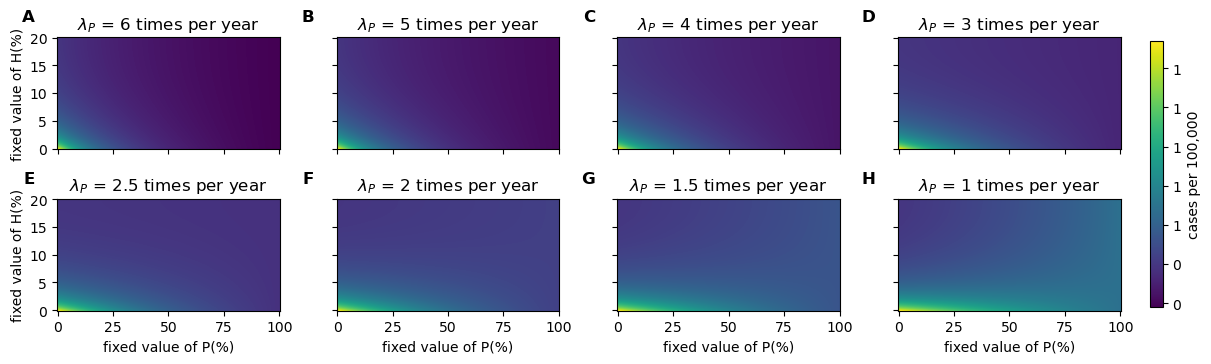

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define parameters
args = {
    "beta_HIV": 0.6341 / 360.0,
    "beta_STI": 0.0016 * 5.0,
    "mu": 1.0 / 45.0 / 360.0,
    "gamma_STI": 1.0 / 1.32 / 360.0,
    "gammaT_STI": 1.0 / 14.0,
    "lambda_P": 1 / 3 / 360,
    "asymptomatic": 0.9,
    "m_max": 0.8,
    "H_thres": 0.1,
    "m_eps": 0.01,
    "Phi_r": 40.0,
    "H_tau": 0.2,
    "c": 50.0,
    "minexp": 0,
    "H": 0,
    "P_HIV": 0.0,
    "maxexp": 1,
}


# Mitigation function
def m(H, min_exp=args["minexp"], max_exp=args["maxexp"], tau_exp=args["H_tau"]):
    return min_exp + (max_exp - min_exp) * (1 - np.exp(-H / tau_exp))


# Define the equation for alpha
def alpha(P, H, beta_STI=args["beta_STI"]):
    return beta_STI * (1 - m(H) * (1 - P))


# Define the equation for I^{a,*}_{STI}
def I_star_STI(
    H,
    P,
    lam_P,
    beta_HIV=args["beta_HIV"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    C=args["c"],
    psi=args["asymptomatic"],
    tgamma=args["gammaT_STI"],
):
    P_star = P
    H_star = H
    m_star = m(H_star)
    alpha_val = alpha(P_star, H_star)

    term1 = (mu + tgamma) * (
        mu
        / (
            (
                psi
                * alpha_val
                * mu
                / (
                    gamma
                    + lam_P * P_star
                    + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
                    + mu
                )
                + (1 - psi) * alpha_val
            )
            - 1
        )
    )
    term2 = (
        -(
            gamma
            + lam_P * P_star
            + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
            + mu
        )
        / psi
    )
    term3 = gamma - tgamma * (
        (
            1
            + (
                gamma
                + lam_P * P_star
                + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
                + mu
            )
            / mu
        )
        * (1 - psi)
        / psi
    )

    numerator = term1
    denominator = term2 + term3

    return numerator / denominator


# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360,
    5 / 360,
    4 / 360,
    3 / 360,
    2.5 / 360,
    2 / 360,
    1.5 / 360,
    1 / 360,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

# Calculate I_star_STI values for each combination of H, P, and lambda_P
results = {}
for lambda_P in lambda_P_values:
    I_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            I_values[i, j] = I_star_STI(H, P, lambda_P)
    results[lambda_P] = I_values

# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Plotting
num_lambda_P = len(lambda_P_values)
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

plt.show()

In [20]:
import numpy as np
from scipy.optimize import minimize

# Define the system of equations
def equations(vars):
 Ssti, Iasti, Issti, Tsti = vars
 eq1 = -beta_0_STI * (1 - m_H * (1 - P)) * (Iasti + Issti) * Ssti + gamma * Iasti + tilde_gamma * Tsti + Phi - mu * Ssti - Sigma
 eq2 = psi * beta_0_STI * (1 - m_H * (1 - P)) * (Iasti + Issti) * Ssti - gamma * Iasti - lambda_a_PH * Iasti - mu * Iasti + psi * Sigma
 eq3 = (1 - psi) * beta_0_STI * (1 - m_H * (1 - P)) * (Iasti + Issti) * Ssti - lambda_s_PH * Issti - mu * Issti + (1 - psi) * Sigma
 eq4 = lambda_a_PH * Iasti + lambda_s_PH * Issti - tilde_gamma * Tsti - mu * Tsti
 return np.array([eq1, eq2, eq3, eq4])

# Define the constraint S+I+T=1
def constraint(vars):
 Ssti, Iasti, Issti, Tsti = vars
 return Ssti + Iasti + Issti + Tsti - 1

# Initial guess
x0 = np.array([1, 0.001, 0.0, 0.0])

# Define the bounds for the variables
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

# Define the constraints
con = {'type': 'eq', 'fun': constraint}

# Solve the system of equations with the constraint
sol = minimize(lambda x: np.sum(equations(x)**2), x0, method='SLSQP', bounds=bounds, constraints=con)

print(sol.x)


[0.00000000e+00 1.00000000e+00 0.00000000e+00 8.32667268e-16]
